#### Vicky van der Wagt

## Naive Bayes on Political Text

In this notebook we use Naive Bayes to explore and classify political data. See the `README.md` for full details. You can download the required DB from the shared dropbox or from blackboard

In [1]:
import sqlite3
import nltk
import random
import numpy as np
from collections import Counter, defaultdict

# Feel free to include your text patterns functions
#from text_functions_solutions import clean_tokenize, get_patterns
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#connect to database file
convention_db = sqlite3.connect("2020_Conventions.db")
#generate cursor object to generate sql commands
convention_cur = convention_db.cursor()

# use a PRAGMA statement to get table info (column names, datatypes, whether primary key)
convention_cur.execute("PRAGMA table_info(conventions)")

# fetch the results
rows = convention_cur.fetchall()

# print results
for row in rows:
    print(row)

(0, 'party', 'TEXT', 0, None, 0)
(1, 'night', 'INTEGER', 0, None, 0)
(2, 'speaker', 'TEXT', 0, None, 0)
(3, 'speaker_count', 'INTEGER', 0, None, 0)
(4, 'time', 'TEXT', 0, None, 0)
(5, 'text', 'TEXT', 0, None, 0)
(6, 'text_len', 'TEXT', 0, None, 0)
(7, 'file', 'TEXT', 0, None, 0)


### Add data cleaning functions

In [3]:
sw = stopwords.words("english")
punctuation = set(punctuation)

def remove_stopwords(tokens) :
    """This function removes stopwords (sw) from text. """
    
    tokens = [token for token in tokens if token not in sw]
    
    return(tokens)

def tokenize(text) : 
    """ This function splits text on whitespace, and folds to lowercase. """
    tokens = word_tokenize(text.lower())
    return(tokens)

def remove_punctuation(text, punct_set=punctuation) : 
    """ This function removes punctuation. """
    
    return("".join([ch for ch in text if ch not in punctuation]))

def process_text(text, pipeline):
    """ This function is used to apply functions to text. """
    for function in pipeline:
        text = function(text)
    return text


### Part 1: Exploratory Naive Bayes

We'll first build a NB model on the convention data itself, as a way to understand what words distinguish between the two parties. This is analogous to what we did in the "Comparing Groups" class work. First, pull in the text 
for each party and prepare it for use in Naive Bayes.  

In [4]:
convention_data = []

# fill this list up with items that are themselves lists. The 
# The first element in the sublist should be the cleaned and tokenized
# text in a single string. As part of your cleaning process,
# remove the stopwords from the text. The second element of the sublist
# should be the party. 

#add functions to our text pipeline
text_pipeline = [remove_punctuation, tokenize, remove_stopwords]


query_results = convention_cur.execute(
                            '''
                            SELECT [text], [party] from conventions
                            ''')

for row in query_results :
    #store the first column as text and the second column as party
    text = row[0] 
    party = row[1]  # 
    # clean the text using our text pipeline
    cleaned_text = process_text(text, text_pipeline)
    convention_data.append([cleaned_text, party])
       

Let's look at some random entries and see if they look right. 

In [5]:
random.choices(convention_data,k=5)

[[['wisconsin'], 'Democratic'],
 [['found',
   'leader',
   'vice',
   'president',
   'soon',
   'president',
   'joe',
   'biden'],
  'Democratic'],
 [['’',
   'speaker',
   'would',
   'bring',
   'gun',
   'bill',
   'floor',
   '’',
   'speaker',
   'would',
   'bring',
   'dreamer',
   '’',
   'issue',
   'floor'],
  'Democratic'],
 [['yeah'], 'Democratic'],
 [['factory',
   'workers',
   'ohio',
   'faced',
   'dangerous',
   'conditions',
   'administration',
   '’',
   'given',
   'clear',
   'guidance',
   'protect',
   'people'],
  'Democratic']]

If that looks good, we now need to make our function to turn these into features. In my solution, I wanted to keep the number of features reasonable, so I only used words that occur at least `word_cutoff` times. Here's the code to test that if you want it. 

In [6]:
word_cutoff = 35

#tokens = [w for t, p in convention_data for w in t.split()]

#saves tokens as the words in our convention data text
tokens = [w for t, p in convention_data for w in t]

# nltk.FreqDist calculates the frequency distribution of tokens
word_dist = nltk.FreqDist(tokens)

# generate empty set to store our feature words 
feature_words = set()

# if word count exceeds the word cutoff, add word to the feature_words set
for word, count in word_dist.items() :
    if count > word_cutoff :
        feature_words.add(word)
        
print(f"With a word cutoff of {word_cutoff}, we have {len(feature_words)} as features in the model.")

With a word cutoff of 35, we have 424 as features in the model.


In [7]:
def conv_features(text,fw) :
    """Given some text, this returns a dictionary holding the
       feature words.
       
       Args: 
            * text: a piece of text in a continuous string. Assumes
            text has been cleaned and case folded.
            * fw: the *feature words* that we're considering. A word 
            in `text` must be in fw in order to be returned. This 
            prevents us from considering very rarely occurring words.
        
       Returns: 
            A dictionary with the words in `text` that appear in `fw`. 
            Words are only counted once. 
            If `text` were "quick quick brown fox" and `fw` = {'quick','fox','jumps'},
            then this would return a dictionary of 
            {'quick' : True,
             'fox' :    True}
    """
    #initate empty dictionary
    ret_dict = {}
    
    #if the text is a string...
    if isinstance(text, str):
        # convert string to list of words by splitting on whitespace
        text = text.split()
    
    #for words in the text
    for word in text:
        #if the word is not in feature words and not already in our dictionary...
        if word in fw and word not in ret_dict:
            # add word to dictionary with a True value
            ret_dict[word] = True
    #return the dictionary        
    return ret_dict


In [8]:
#assert statements to double check our function conv_features is working as expected
#did not pass assert statements with much higher feature counts
assert(len(feature_words)>0)
assert(conv_features("donald is the president",feature_words)==
       {'donald':True,'president':True})
assert(conv_features("some people in america are citizens",feature_words)==
                     {'people':True,'america':True,"citizens":True})

Now we'll build our feature set. Out of curiosity I did a train/test split to see how accurate the classifier was, but we don't strictly need to since this analysis is exploratory. 

In [9]:
# generate list of feature sets
featuresets = [(conv_features(text,feature_words), party) for (text, party) in convention_data]

In [10]:
random.seed(20220507)
random.shuffle(featuresets)

#define test size
test_size = 500

In [11]:
#split data into training and testing
test_set, train_set = featuresets[:test_size], featuresets[test_size:]
#train Naive Bayes classifier model using training data
classifier = nltk.NaiveBayesClassifier.train(train_set)
#get the accuracy 
print(nltk.classify.accuracy(classifier, test_set))

0.488


In [12]:
# show 25 most informative features
classifier.show_most_informative_features(25)

Most Informative Features
                   china = True           Republ : Democr =     27.1 : 1.0
                   votes = True           Democr : Republ =     23.8 : 1.0
             enforcement = True           Republ : Democr =     21.5 : 1.0
                 climate = True           Democr : Republ =     17.8 : 1.0
                   media = True           Republ : Democr =     15.8 : 1.0
                   trade = True           Republ : Democr =     12.7 : 1.0
                  cities = True           Republ : Democr =      9.5 : 1.0
                 freedom = True           Republ : Democr =      9.0 : 1.0
                    land = True           Republ : Democr =      8.6 : 1.0
                    true = True           Republ : Democr =      8.5 : 1.0
                grateful = True           Republ : Democr =      8.4 : 1.0
                greatest = True           Republ : Democr =      8.4 : 1.0
                  choice = True           Republ : Democr =      8.2 : 1.0

Write a little prose here about what you see in the classifier. Anything odd or interesting?

### My Observations

Most of the informative features are words which are highly associated with the Republican party. This indicates that it is easier to classify whether a user is Republican, based on the high number of words that are associated with this class in the model. 

## Part 2: Classifying Congressional Tweets

In this part we apply the classifer we just built to a set of tweets by people running for congress
in 2018. These tweets are stored in the database `congressional_data.db`. That DB is funky, so I'll
give you the query I used to pull out the tweets. Note that this DB has some big tables and 
is unindexed, so the query takes a minute or two to run on my machine.

In [13]:
#connect to specified database
cong_db = sqlite3.connect("congressional_data.db")
#create cursor object
cong_cur = cong_db.cursor()

In [14]:
#select distinct candidate, party & tweet combos, filter for 2 parties
results = cong_cur.execute(
        '''
           SELECT DISTINCT 
                  cd.candidate, 
                  cd.party,
                  tw.tweet_text
           FROM candidate_data cd 
           INNER JOIN tweets tw ON cd.twitter_handle = tw.handle 
               AND cd.candidate == tw.candidate 
               AND cd.district == tw.district
           WHERE cd.party in ('Republican','Democratic') 
               AND tw.tweet_text NOT LIKE '%RT%'
        ''')

results = list(results) # Just to store it, since the query is time consuming

In [15]:
#preview the results
results[0:5]

[('Mo Brooks',
  'Republican',
  b'"Brooks Joins Alabama Delegation in Voting Against Flawed Funding Bill" http://t.co/3CwjIWYsNq'),
 ('Mo Brooks',
  'Republican',
  b'"Brooks: Senate Democrats Allowing President to Give Americans\xe2\x80\x99 Jobs to Illegals" #securetheborder https://t.co/mZtEaX8xS6'),
 ('Mo Brooks',
  'Republican',
  b'"NASA on the Square" event this Sat. 11AM \xe2\x80\x93 4PM. Stop by &amp; hear about the incredible work done in #AL05! @DowntownHSV http://t.co/R9zY8WMEpA'),
 ('Mo Brooks',
  'Republican',
  b'"The trouble with Socialism is that eventually you run out of other people\'s money." - Margaret Thatcher https://t.co/X97g7wzQwJ'),
 ('Mo Brooks',
  'Republican',
  b'"The trouble with socialism is eventually you run out of other people\'s money" \xe2\x80\x93 Thatcher. She\'ll be sorely missed. http://t.co/Z8gBnDQUh8')]

In [16]:
tweet_data = []

# Now fill up tweet_data with sublists like we did on the convention speeches.
# Note that this may take a bit of time, since we have a lot of tweets.

#for each row in results, extract these columns
for row in results:
    candidate = row[0]  
    party = row[1]
    tweet_text = row[2]
    
    #if tweet is encoded as bytes
    if isinstance(tweet_text, bytes):
        #decode as string
        tweet_text = tweet_text.decode('utf-8')
    
    #clean text using our preprocessing pipeline
    cleaned_text = process_text(tweet_text, text_pipeline)
    #append candidate, party, and cleaned text to tweet_data
    tweet_data.append([candidate, party, cleaned_text])


There are a lot of tweets here. Let's take a random sample and see how our classifer does. I'm guessing it won't be too great given the performance on the convention speeches...

In [17]:
random.seed(20201015)

tweet_data_sample = random.choices(tweet_data,k=10)

In [18]:
tweet_data_sample

[['Daniel Webster',
  'Republican',
  ['couple',
   'lakegov',
   'officials',
   'stopped',
   'office',
   'share',
   'priorities',
   'amp',
   'provide',
   'updates',
   'community',
   'httpstcoffjqezd5vz']],
 ['John Carter',
  'Republican',
  ['great',
   'discussion',
   'bluelivesmatter',
   'amp',
   'veterans',
   'w',
   'timconstantine1',
   'today',
   'rncincle',
   'iendorsetrumppence16',
   'httpstcorgmakt1ut4']],
 ['Bill Johnson',
  'Republican',
  ['opening',
   'mornings',
   'drug',
   'abuse',
   'addiction',
   'prevention',
   'summit',
   'jackson',
   'county',
   'httpstco6xujf97afc']],
 ['Debra Haaland',
  'Democratic',
  ['proud',
   'endorsed',
   'former',
   'nm',
   'lt',
   'gov',
   'amp',
   'champion',
   'women',
   'healthcare',
   'education',
   'amp',
   'democrats',
   'dddnm',
   'nmpol',
   'deb4congress',
   'httpstco0ke8dc76ze']],
 ['Frank Pallone',
  'Democratic',
  ['congressman',
   'pallone',
   'successfully',
   'worked',
   'stop',

In [19]:
for candidate, party, tweet in tweet_data_sample:
    #initialize dictionary to hold tweet features
    tweet_features = {}  
    
    #for each token in tweet, set as a feature in the tweets dictionary
    for token in tweet:
        tweet_features[token] = True
    
    # use our classifier to predict party
    estimated_party = classifier.classify(tweet_features)
    
    # Print the results
    print(f"Here's our (cleaned) tweet: {tweet}")
    print(f"Actual party is {party} and our classifier says {estimated_party}.")
    print("")

Here's our (cleaned) tweet: ['couple', 'lakegov', 'officials', 'stopped', 'office', 'share', 'priorities', 'amp', 'provide', 'updates', 'community', 'httpstcoffjqezd5vz']
Actual party is Republican and our classifier says Republican.

Here's our (cleaned) tweet: ['great', 'discussion', 'bluelivesmatter', 'amp', 'veterans', 'w', 'timconstantine1', 'today', 'rncincle', 'iendorsetrumppence16', 'httpstcorgmakt1ut4']
Actual party is Republican and our classifier says Republican.

Here's our (cleaned) tweet: ['opening', 'mornings', 'drug', 'abuse', 'addiction', 'prevention', 'summit', 'jackson', 'county', 'httpstco6xujf97afc']
Actual party is Republican and our classifier says Democratic.

Here's our (cleaned) tweet: ['proud', 'endorsed', 'former', 'nm', 'lt', 'gov', 'amp', 'champion', 'women', 'healthcare', 'education', 'amp', 'democrats', 'dddnm', 'nmpol', 'deb4congress', 'httpstco0ke8dc76ze']
Actual party is Democratic and our classifier says Republican.

Here's our (cleaned) tweet: ['con

Now that we've looked at it some, let's score a bunch and see how we're doing.

Modified to score all

In [20]:
# dictionary of counts by actual party and estimated party. 
# first key is actual, second is estimated


# initialize dictionary to hold the counts
results = defaultdict(lambda: defaultdict(int))

for candidate, party, tweet_list in tweet_data:
    #initialize empty list to hold tweet features
    tweet_features = {}  
    
    # join list of words into one tweet
    tweet = ' '.join(tweet_list)
    
    # split into tokens based on whitespace
    tokens = tweet.split() 
    
    # For each token, set the feature to True if it's present in the tweet
    for token in tokens:
        tweet_features[token] = True
    
    # predict party using our nb classifier
    estimated_party = classifier.classify(tweet_features)
    
    # increment counts for the actual party as well as the predicted party
    results[party][estimated_party] += 1


In [21]:
results

defaultdict(<function __main__.<lambda>()>,
            {'Republican': defaultdict(int,
                         {'Democratic': 75737, 'Republican': 212794}),
             'Democratic': defaultdict(int,
                         {'Republican': 283728, 'Democratic': 92397})})

Visualize Results in Confusion Matrix

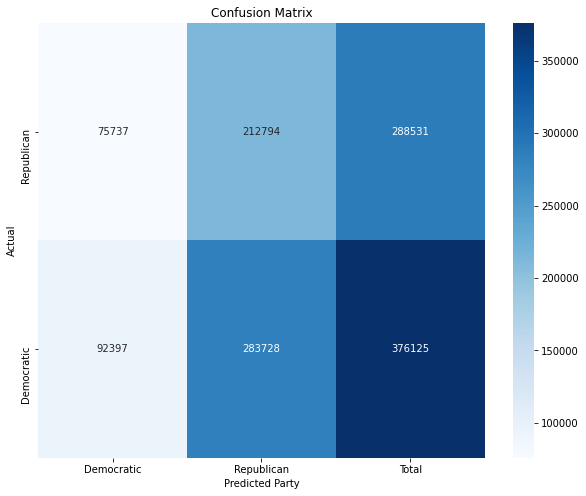

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#convert results to dataframe for confusion matrix
confusion_df = pd.DataFrame(results).T.fillna(0)

#get actual totals for visualization
confusion_df['Total'] = confusion_df.sum(axis=1)


#plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_df, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Party')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Reflections

_Write a little about what you see in the results_ 

A much higher proportion of the tweets were classified as Republican than Democratic, even though there were more tweets that were actually Democratic. This may be because the most informative features are associated with the Republican party, which means there is an inbalance that will likely bias the model to classify more tweets as Republican. 